## Build a CNN for image recognition.


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

170500096/170498071 [==============================] - 2s 0us/step
shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y),num_class))
    for i, label in enumerate(y):
      results[i,label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [5]:
from keras import optimizers
#hyper parameters
learning_rate = 1E-3 
batch_size = 64

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [6]:
from keras.preprocessing.image import ImageDataGenerator
#data augmentation
train_datagen = ImageDataGenerator(
		rotation_range=15,
		width_shift_range=0.1,
		height_shift_range=0.1,
		horizontal_flip=True,)
train_datagen.fit(x_tr)
train_generator = train_datagen.flow(x_tr, y_tr, batch_size)

In [7]:
steps= int(x_tr.shape[0] / batch_size)
history = model.fit(train_generator, steps_per_epoch = steps, epochs = 100, validation_data=(x_val, y_val))

Epoch 1/100
625/625 [==============================] - 57s 37ms/step - loss: 1.7572 - acc: 0.3558 - val_loss: 1.6941 - val_acc: 0.4257
Epoch 2/100
625/625 [==============================] - 22s 36ms/step - loss: 1.2276 - acc: 0.5585 - val_loss: 1.3674 - val_acc: 0.5690
Epoch 3/100
625/625 [==============================] - 22s 36ms/step - loss: 1.0519 - acc: 0.6230 - val_loss: 0.9105 - val_acc: 0.6792
Epoch 4/100
625/625 [==============================] - 22s 36ms/step - loss: 0.9723 - acc: 0.6544 - val_loss: 0.9758 - val_acc: 0.6671
Epoch 5/100
625/625 [==============================] - 23s 36ms/step - loss: 0.9011 - acc: 0.6835 - val_loss: 0.9406 - val_acc: 0.6879
Epoch 6/100
625/625 [==============================] - 22s 36ms/step - loss: 0.8496 - acc: 0.6985 - val_loss: 0.7504 - val_acc: 0.7444
Epoch 7/100
625/625 [==============================] - 23s 36ms/step - loss: 0.8137 - acc: 0.7178 - val_loss: 0.9229 - val_acc: 0.6999
Epoch 8/100
625/625 [==============================] - 

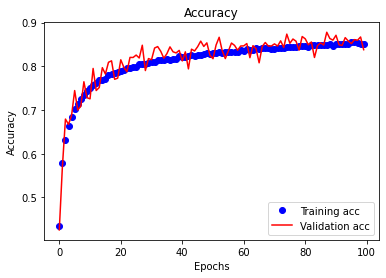

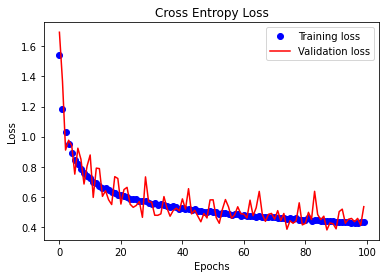

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss= history.history['val_loss']

epochs = range(len(acc))

plt.title('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.title('Cross Entropy Loss')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

In [9]:
#<Compile your model again (using the same hyper-parameters)>
#hyper parameters
learning_rate = 1E-3 
batch_size = 64
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [10]:
#<Train your model on the entire training set (50K samples)>
#<Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
#<Do NOT use the validation_data option (because now you do not have validation data)>
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train_vec, batch_size)
steps= int(x_train.shape[0] / batch_size)
history = model.fit(train_generator, steps_per_epoch = steps, epochs = 100)

Epoch 1/100
781/781 [==============================] - 28s 34ms/step - loss: 0.4531 - acc: 0.8457
Epoch 2/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4488 - acc: 0.8457
Epoch 3/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4388 - acc: 0.8509
Epoch 4/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4439 - acc: 0.8483
Epoch 5/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4484 - acc: 0.8462
Epoch 6/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4430 - acc: 0.8476
Epoch 7/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4369 - acc: 0.8488
Epoch 8/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4452 - acc: 0.8459
Epoch 9/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4382 - acc: 0.8484
Epoch 10/100
781/781 [==============================] - 27s 35ms/step - loss: 0.4278 - acc: 0.8517
Epoch 11/100
781/78

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [11]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.3988 - acc: 0.8697
loss = 0.3987782597541809
accuracy = 0.869700014591217
